### 1.包导入

In [1]:
import gym
import torch as T
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
from torch.distributions import Categorical
import numpy as np
import pickle
import os
import matplotlib.pyplot as plt 

### 2.环境尝试

In [2]:
env = gym.make('CartPole-v1')
env.reset()
env.step(0)


(array([ 0.02293258, -0.2449544 ,  0.01957209,  0.3406646 ], dtype=float32),
 1.0,
 False,
 False,
 {})

### 3.定义策略网络

In [3]:
# 定义策略网络
class PolicyNetwork(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(PolicyNetwork, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 128)   # 隐藏层
        self.fc3 = nn.Linear(128, output_dim)  # 输出动作概率
        self.device = T.device("cuda" if T.cuda.is_available() else "cpu")
        self.to(self.device)
        
    def forward(self, x):
        x = T.tensor(x, dtype=T.float32).to(self.device) 
        layer1 = T.relu(self.fc1(x))
        layer2 = T.relu(self.fc2(layer1))
        p = T.softmax(self.fc3(layer2), dim=-1)
        return p

### 4.计算折扣奖励函数

In [4]:
# 计算折扣奖励
def compute_returns(rewards, gamma):
    returns = []
    G = 0
    for r in reversed(rewards):
        G = r + gamma * G
        returns.insert(0, G)
    return returns

### 5.设置环境和超参数

In [5]:
# 设置环境
env = gym.make('CartPole-v1')
input_dim = env.observation_space.shape[0]  # 输入维度
output_dim = env.action_space.n             # 输出维度
# 设置超参数
batch_size = 10 # 设置每次更新的轨迹数量
gamma = 0.9  # 奖励折扣因子
avg_episode = 50
save_episode = 500
print_episode = 50
clip_norm = 100
continue_train = True
num_episodes = 5000
learning_rate = 0.0001

# 学习进度保存路径
model_path = "./save/s3_policy_net.pth"
avg_path = "./save/s3_avg_rewards.pth"

In [6]:
policy_net = PolicyNetwork(input_dim, output_dim)
optimizer = optim.AdamW(policy_net.parameters(), lr=learning_rate)
avg_rewards = []

if continue_train:
    if os.path.exists(model_path) and os.path.exists(avg_path):
        policy_net.load_state_dict(T.load(model_path))
        policy_net.to(policy_net.device)
        with open(avg_path, "rb") as f:
            avg_rewards = pickle.load(f)
len(avg_rewards)

0

### 6.开始训练

In [7]:

# 开始训练
record_rewards = []
for episode in range(1,num_episodes+1):
    log_probs = []
    total_returns = []
    for _ in range(batch_size):
        # state = torch.tensor(env.reset()[0], dtype=torch.float32).to(policy_net.device)
        
        rewards = []
        state = env.reset()[0]
        # 采样轨迹
        done = False
        while not done:
            
            # state = torch.tensor(np.array(state), dtype=torch.float32)  # Ensure state tensor is on the correct device
            probs = policy_net(state)
            m = Categorical(probs) # 创建一个类别分布
            action = m.sample()  # 采样动作
            log_probs.append(m.log_prob(action))  # 记录 log(prob)
            # 执行动作
            state, reward, terminated, truncated, info = env.step(action.item())
            state = T.tensor(state, dtype=T.float32).to(policy_net.device)
            # print(f"state: {state}")
            done = bool(terminated) or bool(truncated)  # Ensure done is a boolean value
            rewards.append(reward)

        # 记录本次总得分 
        record_rewards.append(sum(rewards))

        # 计算累计回报
        returns = compute_returns(rewards, gamma)
        total_returns+=returns
    total_returns = T.tensor(total_returns, dtype=T.float32).to(policy_net.device)  # Ensure returns tensor is on the correct device
    
    # 计算损失
    policy_loss = []
    for log_prob, G in zip(log_probs, total_returns):
        policy_loss.append(-log_prob * G)  # REINFORCE的损失：-log_prob * G
    policy_loss = T.stack(policy_loss).sum()
    
    # 反向传播和优化
    optimizer.zero_grad()
    policy_loss.backward()
    nn.utils.clip_grad_norm_(policy_net.parameters(), max_norm=clip_norm)
    optimizer.step()
    
    # 输出训练进度
    if episode % avg_episode == 0:
        avg_reward = sum(record_rewards[-avg_episode:])/avg_episode
        avg_rewards.append(avg_reward)
        if episode % print_episode == 0:
            print(f"Episode {episode}, Current Reward:{record_rewards[-1]}, Avg Reward: {avg_reward}")
        if episode % save_episode == 0:
            print(f"to save model and avg_rewards {len(avg_rewards)}")
            T.save(policy_net.state_dict(),model_path)
            with open(avg_path, "wb") as f:
                pickle.dump(avg_rewards, f)



/tmp/ipykernel_29626/3120889130.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = T.tensor(x, dtype=T.float32).to(self.device)


Episode 50, Current Reward:20.0, Avg Reward: 30.58
Episode 100, Current Reward:24.0, Avg Reward: 31.72
Episode 150, Current Reward:10.0, Avg Reward: 34.82
Episode 200, Current Reward:23.0, Avg Reward: 41.66
Episode 250, Current Reward:19.0, Avg Reward: 51.84
Episode 300, Current Reward:48.0, Avg Reward: 58.08
Episode 350, Current Reward:21.0, Avg Reward: 62.42
Episode 400, Current Reward:65.0, Avg Reward: 76.24
Episode 450, Current Reward:103.0, Avg Reward: 71.3
Episode 500, Current Reward:70.0, Avg Reward: 105.66
to save model and avg_rewards 10
Episode 550, Current Reward:234.0, Avg Reward: 129.42
Episode 600, Current Reward:124.0, Avg Reward: 150.38
Episode 650, Current Reward:196.0, Avg Reward: 159.84
Episode 700, Current Reward:138.0, Avg Reward: 143.58
Episode 750, Current Reward:20.0, Avg Reward: 161.84
Episode 800, Current Reward:235.0, Avg Reward: 199.84
Episode 850, Current Reward:260.0, Avg Reward: 189.24
Episode 900, Current Reward:71.0, Avg Reward: 177.04
Episode 950, Curr

KeyboardInterrupt: 

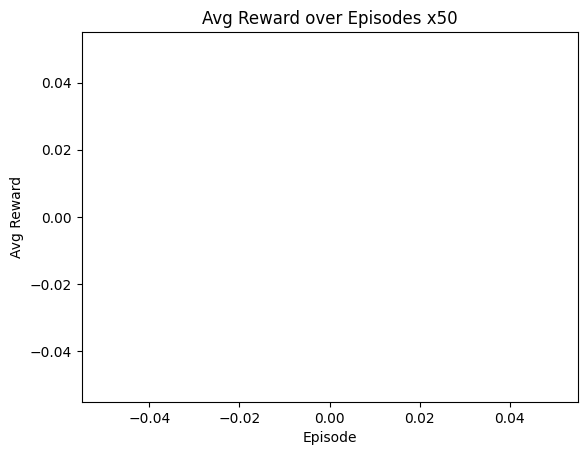

In [8]:

# 绘制得分变化图
plt.plot(range(1, len(avg_rewards) + 1), avg_rewards)
plt.xlabel('Episode')
plt.ylabel('Avg Reward')
plt.title(f'Avg Reward over Episodes x{avg_episode}')
plt.show()